# SGD fit tests

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("../src")

from stochastic_glv_generator import *
from experiments import *
from analysis import *
from inference import *

In [13]:
n = 3
seed = 5
r_max = 1.
A_diag_std = 1.
A_off_diag_std = 0.1

p = sort_glv_params(n, seed, r_max, A_diag_std, A_off_diag_std)
r = p[:n]
A = p[n:].reshape((n, n))
x_eq = -np.linalg.inv(A)@r
print(x_eq)

env_noise = 0.0
t0 = 0
dt = 1e-2

np.random.seed(341242)
init_perturb = np.random.choice([-1., 1.], n)
# init_perturb = -np.ones(n)
init_perturb[init_perturb<0] *= np.random.uniform(0.99, 1., (init_perturb<0).sum())
init_perturb[init_perturb>0] *= np.random.uniform(0.8, 5, (init_perturb>0).sum())
# perturb_scale_list = np.array([0.3, 0.5, 0.8, 1.])
perturb_scale_list = np.random.uniform(0, 1, 1)
t_samp_list = np.linspace(0, 20, 60).reshape((1,-1))
# t_samp_list = np.arange(0, 20+dt, dt)
meas_noise_list = np.array([0.0])
repetitions = 1

replicates = gen_replicates(p, env_noise, init_perturb, perturb_scale_list, t0, dt, t_samp_list, meas_noise_list, repetitions, seed=0, scale_meas_noise_by_abund=True)

[0.57684716 0.47804644 0.58974442]
1/1                                                                                                 

In [14]:
add_time_diff(replicates)
add_log_time_diff(replicates)

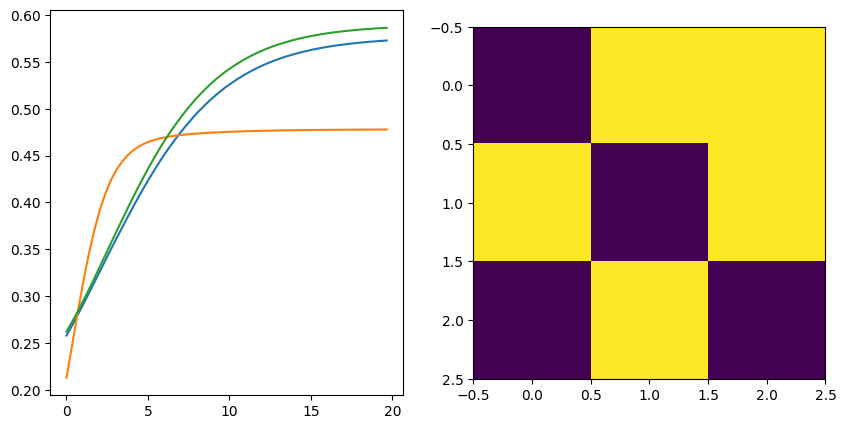

In [15]:
t = replicates.dropna()["time"].values
y = replicates.dropna()[[i for i in replicates.columns if i[:2]=="sp"]].values
dydt = replicates.dropna()[[i for i in replicates.columns if i[:3]=="dsp"]].values

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, y, "-")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(A))
plt.show()

In [16]:
alpha = 1e-3
gamma = 0.9
eps = 1e-7
Eg2 = np.zeros_like(p)

mini_batch_sgd_rmsprop(replicates, p, alpha, gamma, eps, Eg2, 1)

(array([ 0.2371035 ,  0.88180542,  0.22137402, -0.58741249,  0.09558874,
         0.14369655,  0.06027154, -1.90613328,  0.0196802 , -0.03386749,
         0.17472934, -0.43746862]),
 array([4.07755437e-04, 4.56942487e-04, 4.52775184e-04, 7.68749642e-05,
        7.84063401e-05, 8.06479867e-05, 5.25349859e-05, 5.07273149e-05,
        5.46691305e-05, 8.45213808e-05, 8.73481399e-05, 8.86681612e-05]))

0/10000: MSE = 0.1125920976                                                                          

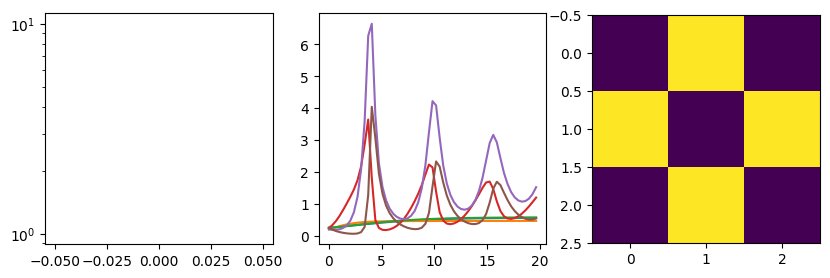

1000/10000: MSE = 0.0015018470                                                                       

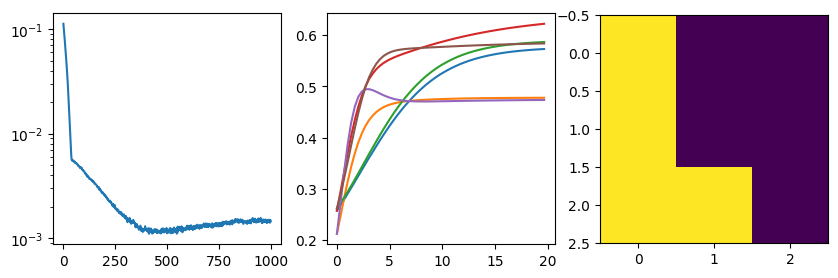

2000/10000: MSE = 0.0018121379                                                                       

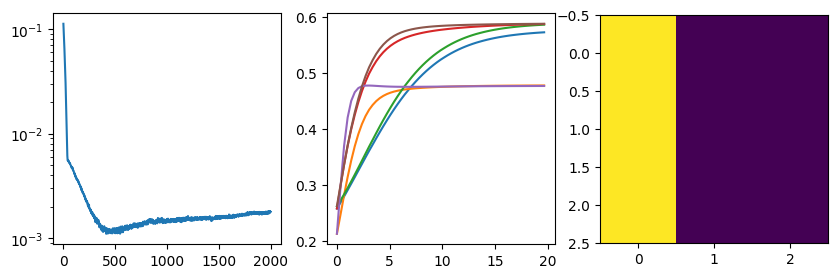

3000/10000: MSE = 0.0021982008                                                                       

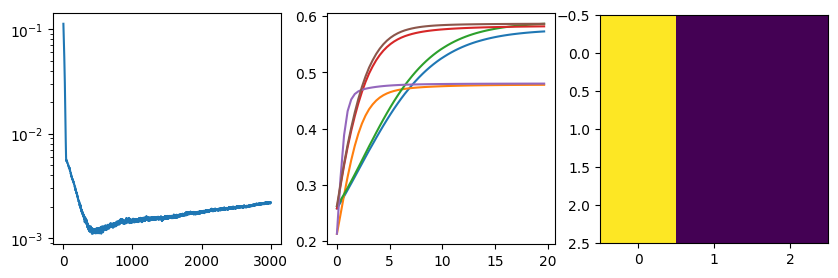

4000/10000: MSE = 0.0024106210                                                                       

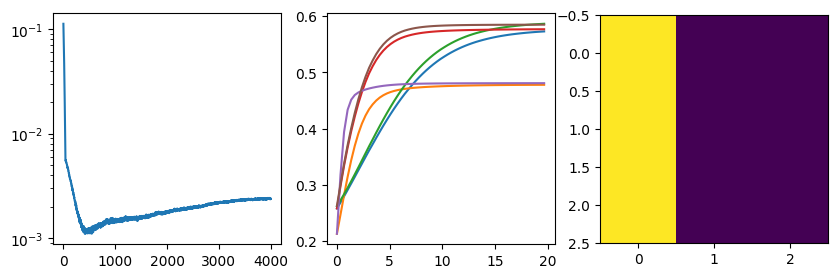

5000/10000: MSE = 0.0024982306                                                                       

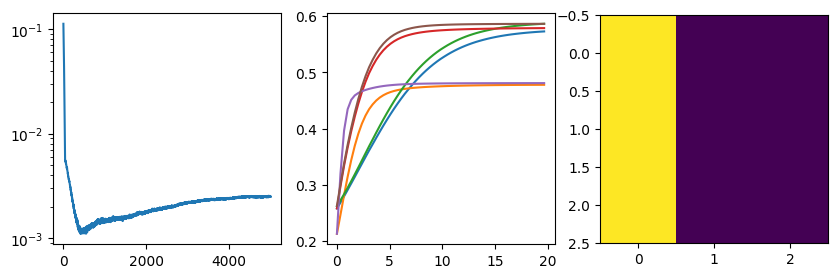

6000/10000: MSE = 0.0025532605                                                                       

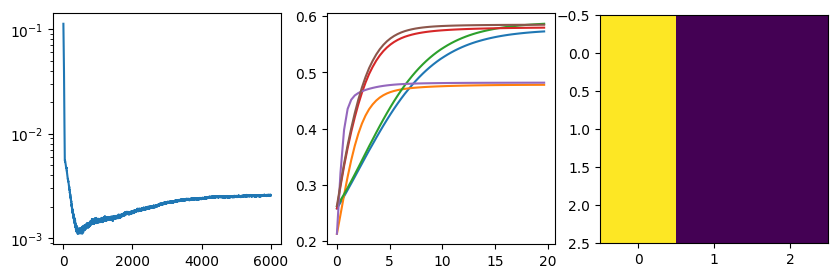

7000/10000: MSE = 0.0025960478                                                                       

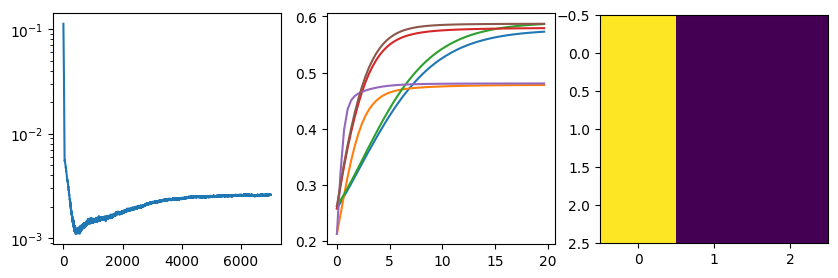

8000/10000: MSE = 0.0025689755                                                                       

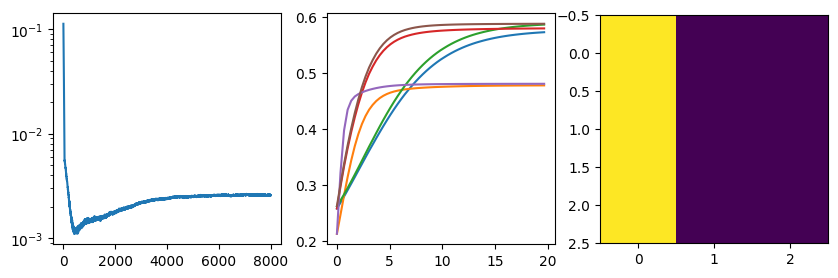

9000/10000: MSE = 0.0025449696                                                                       

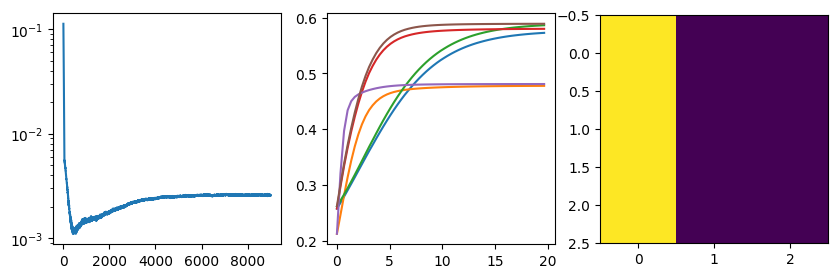

9999/10000: MSE = 0.0025793693                                                                       

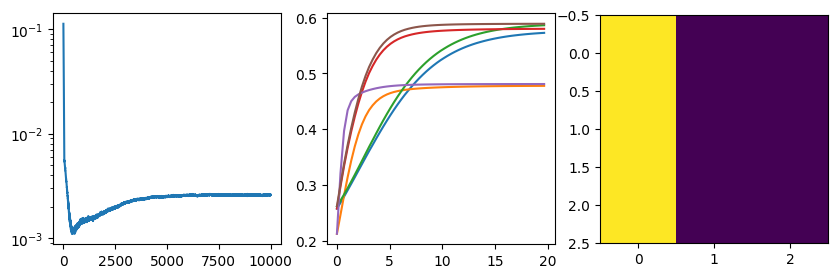

In [20]:
alpha = 1e-3
gamma = 0.9
eps = 1e-7
Eg2 = np.zeros_like(p)

n_steps = 10000
plot_steps = 1000

np.random.seed(1)
p2 = np.random.normal(0, 1, n*(n+1))
# p2 = p * np.random.normal(1, 0., p.shape[0])

p_hist2 = np.zeros((n_steps, p2.shape[0]))
p_hist2[0] = p2

mse_hist = np.zeros(n_steps)

batch_size = 10

for i in range(n_steps):
    
    Eg2 *= 0.
    
    mse_hist[i] = mse(glv_time(t, y, p2), dydt)
    
    p2, Eg2 = mini_batch_sgd_rmsprop(replicates, p2, alpha, gamma, eps, Eg2, batch_size, averaging="none")
    p_hist2[i] = p2
    
    print("\r", " "*100, end="")
    print("\r"+f"{i}/{n_steps}: MSE = {mse_hist[i]:.10f}", end="")
    
    if i % plot_steps == 0:
        
        sol = euler_maruyama(glv, t[0], y[0], p2, 0., dt, t)

        plt.subplots(1, 3, figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.plot(mse_hist[:i])
        plt.yscale("log")
        plt.subplot(1, 3, 2)        
        plt.plot(t, y)
        plt.plot(t, sol)
        plt.subplot(1, 3, 3)
        plt.imshow(np.sign(p2[n:].reshape((n,n))))
        plt.show()
        
plt.subplots(1, 3, figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.plot(mse_hist[:i])
plt.yscale("log")
plt.subplot(1, 3, 2)        
plt.plot(t, y)
plt.plot(t, sol)
plt.subplot(1, 3, 3)
plt.imshow(np.sign(p2[n:].reshape((n,n))))
plt.show()

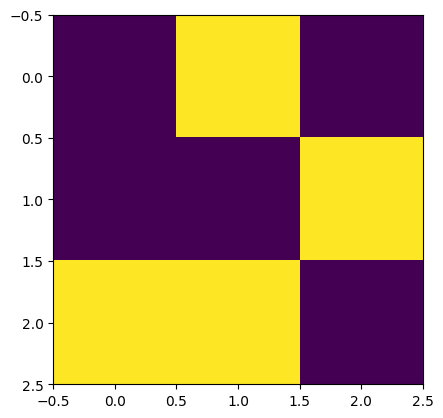

In [19]:
plt.imshow(np.sign(fit_ridge_cv(replicates)[1]))